In [ ]:
#Baseline Analysis

#determine # of unmet draw instances

import pandas as pd 



def return_unmet_draws(data):
    draws = data["Hot Water Outlet Temperature (C)"].values
    cold_water_draws = sum(float(i) < 49 for i in draws)
    return cold_water_draws/len(draws) * 100

site = 90023
nodes = 2
#Compare extreme baselines
#data = pd.read_csv(f"output_site_{site}_60_{nodes}.csv")
#print("Setpoint = 60: ", return_unmet_draws(data))
#data = pd.read_csv(f"output_site_{site}_49_{nodes}.csv")
#print("Setpoint = 49: ", return_unmet_draws(data))

#Check accuracy b/w 2 node and 12 node model
#data_12 = pd.read_csv(f"output_site_{site}_12.csv")
#data_2 = pd.read_csv(f"output_site_{site}_2.csv")
data = pd.read_csv(f"output_site_{site}_control_12.csv")
#from sklearn.metrics import mean_squared_error
return_unmet_draws(data)

#y_test = data_12["Hot Water Outlet Temperature (C)"]
#y_predict = data_2["Hot Water Outlet Temperature (C)"]
#mse = mean_squared_error(y_test, y_predict, multioutput='uniform_average')

#print("2-node: ", mse)

ValueError: could not convert string to float: 'Hot Water Outlet Temperature (C)'

In [36]:
draws = data["Hot Water Outlet Temperature (C)"]
draws_numeric = pd.to_numeric(draws, errors='coerce')  # converts bad strings to NaN
draws_numeric = draws_numeric.dropna().tolist()        # drop NaNs and convert to list

cold_water_draws = sum(float(i) < 49 for i in draws_numeric)
cold_water_draws/len(draws) * 100


0.0848456280933302

In [ ]:
np.

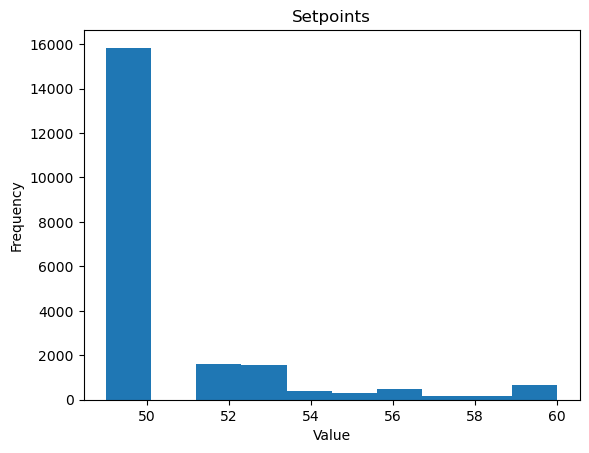

In [43]:
setpoints = pd.to_numeric(data["Setpoint"], errors = 'coerce')

import matplotlib.pyplot as plt
import numpy as np

# Generate some sample data (e.g., from a normal distribution)
# Create the histogram
plt.hist(setpoints)

# Add labels and a title for clarity
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Setpoints")

# Display the plot
plt.show()

In [94]:
y_predict

0         48.390626
1         48.333079
2         48.275653
3         48.218348
4         48.161162
            ...    
464613    55.612407
464614    55.540219
464615    55.468182
464616    55.396295
464617    55.324559
Name: Hot Water Outlet Temperature (C), Length: 464618, dtype: float64

In [ ]:
# Test against data driven model
data_12 = pd.read_csv(f"output_site_{site}_12.csv")
X_val, y_val = csv_to_features(data_12)


from sklearn.metrics import r2_score
y_predict_val = model.predict(X_val)

r_2_val = r2_score(y_val, y_predict_val)
print(f"test coefficient of determination: {r_2_val}")

from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_val, y_predict_val, multioutput='uniform_average')
print("Mean Squared Error:", mse)



464618 464618 464618
test coefficient of determination: 0.4278689954408051
Mean Squared Error: 7.020160980186185


In [88]:
#filter out temperatures below 40
X_val_filtered = []
y_val_filtered = []
for x, y in zip(X_val, y_val):
    if all(val >= 40 for val in y):
        X_val_filtered.append(x)
        y_val_filtered.append(y)
X_val = X_val_filtered
y_val = y_val_filtered

y_predict_val = model.predict(X_val)

r_2_val = r2_score(y_val, y_predict_val)
print(f"test coefficient of determination: {r_2_val}")

mse = mean_squared_error(y_val, y_predict_val, multioutput='uniform_average')
print("Mean Squared Error:", mse)

test coefficient of determination: 0.42350896883435973
Mean Squared Error: 6.985622843907615


Input: Ochre Equipment Reading Output
Trains Regression models based on 15 minute increments of , Node Temp, Draw Data, and Setpoint

In [20]:
#import data
import pandas as pd
import numpy as np

#Data transformation, Y-values are y_i+1 temperatures for the next hour
def rolling_subsets(input_list, window_size = 4):
    if window_size > len(input_list) or window_size <= 0:
        raise ValueError("Window size must be positive and not greater than the list length.")
    
    return [input_list[i:i + window_size] for i in range(int(len(input_list)))]

import numpy as np

def csv_to_features(df, type = 1): #exports features, y = 15 minute increment predictions for 1 hour of outlet temperature
        
    y_col = df["Hot Water Outlet Temperature (C)"]
    window = 8 #2 hours
    result = rolling_subsets(y_col, window)

    power = df["Average Electric Power"]
   

    if type == 2: #EWH
        # Create feature vectors
        T_u = [value if mode == "Upper On" else 0 for value, mode in zip(df["Average Electric Power"], df["Water Heating Mode"])]
        T_m = [value if mode == "Lower On" else 0 for value, mode in zip(df["Average Electric Power"], df["Water Heating Mode"])]
        xu = rolling_subsets(T_u, window)
        xl = rolling_subsets(T_m, window)

        x2 = rolling_subsets(df["Draw Data (L)"], window)
        x3 = rolling_subsets(df["Setpoint (C)"], window)
        x4 = df["T_WH3"]
        x5 = df["T_WH10"]

    else: #HPWH
        # Create feature vectors
        T_u = [value if mode == "Upper On" else 0 for value, mode in zip(df["Average Electric Power"], df["Water Heating Mode"])]
        T_m = [value if mode == "Lower On" else 0 for value, mode in zip(df["Average Electric Power"], df["Water Heating Mode"])]
        T_h = [value if mode == "Heat Pump On" else 0 for value, mode in zip(df["Average Electric Power"], df["Water Heating Mode"])]
        
        xu = rolling_subsets(T_u, window)
        xl = rolling_subsets(T_m, window)
        xh = rolling_subsets(T_h, window)
        
        x2 = rolling_subsets(df["Draw Data"], window)
        x3 = rolling_subsets(df["Setpoint"], window)
        x4 = df["T_WH3"]
        x5 = df["T_WH10"]
        xh_v = xh[:-window]

    print(len(result), len(x2), len(x3))


    y = result[:-window]  # Remove the first index to offset, y = i+1th prediction
    xl_v = xl[:-window]  # Water Heater Power
    xu_v = xu[:-window]

    x2_v = x2[:-window] #draw values
    x3_v = x3[:-window] #setpoint values
    x4_v = x4[:-window] #noe temperatures should only be taken at current time interval (live readings)
    x5_v = x5[:-window]


    # Stack features
    if type == 2:
        X = np.column_stack([x2_v, xu_v, xl_v, x4_v, x5_v]) 
    else:
        X = np.column_stack([x2_v, x3_v, xu_v, xl_v, xh_v, x4_v, x5_v]) #Draw value, setpoint(?), upper node powr, lower node power, heat pump power, upper node temp, lowe rnode temp
    return X, y


In [36]:
#data = pd.read_csv("output_site_10292.csv")  90023

type = 1 

if type == 1: # HPWH
    data = pd.read_csv("output_site_90023.csv")

else: #EWH

    data = pd.read_csv("output_site_90023_ewh.csv")
    
    
X, y = csv_to_features(data, type)

#data1 = pd.read_csv("output_site_null.csv")
#X1, y1 = csv_to_features(data1)





929236 929236 929236


In [37]:
y

[0    48.352419
 1    48.264842
 2    48.257316
 3    48.158983
 4    48.061725
 5    48.126652
 6    48.029570
 7    48.024207
 Name: Hot Water Outlet Temperature (C), dtype: float64,
 1    48.264842
 2    48.257316
 3    48.158983
 4    48.061725
 5    48.126652
 6    48.029570
 7    48.024207
 8    47.926482
 Name: Hot Water Outlet Temperature (C), dtype: float64,
 2    48.257316
 3    48.158983
 4    48.061725
 5    48.126652
 6    48.029570
 7    48.024207
 8    47.926482
 9    47.829830
 Name: Hot Water Outlet Temperature (C), dtype: float64,
 3     48.158983
 4     48.061725
 5     48.126652
 6     48.029570
 7     48.024207
 8     47.926482
 9     47.829830
 10    47.892911
 Name: Hot Water Outlet Temperature (C), dtype: float64,
 4     48.061725
 5     48.126652
 6     48.029570
 7     48.024207
 8     47.926482
 9     47.829830
 10    47.892911
 11    47.796447
 Name: Hot Water Outlet Temperature (C), dtype: float64,
 5     48.126652
 6     48.029570
 7     48.024207
 8     4

In [38]:
#Separate inputs and outputs based on window to train for each timestep individually
import numpy as np
window = 8
inputs = []
outputs = []
for i in range(window):
    
    if type == 1:
        cols = list(range(i + 1)) + list(range(window, window + i + 1)) + list(range(2 * window, 2 * window + i + 1)) + list(range(3 * window, 3 * window + i + 1)) + list(range(4 * window, 4 * window + i + 1)) + [-2, -1]
    else:
        cols = list(range(i + 1)) + list(range(window, window + i + 1)) + list(range(2 * window, 2 * window + i + 1))  + [-2, -1]
    inputs.append(X[:, cols])
    outputs.append([s.iloc[i] for s in y])
    


### Train a regressor to predict each outlet temperature individually

For each value y_i in Y, we set x_i to {d_0, d_1, ... d_i, p_0, p_1, ... p_i, T_1, T_2}

In [39]:
#Train test split 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

coeffs = []
intercepts = []
for i in range(8):
    print(i)
    X_train, X_test, y_train, y_test = train_test_split(inputs[i], outputs[i], test_size=0.2, random_state=42)
    model = LinearRegression()
    model.fit(X_train,y_train)
    r_sq = model.score(X_train, y_train)
    print(f"Training coefficient of determination: {r_sq}")
    y_predict = model.predict(X_test)
    test_r_sq = model.score(X_test, y_test)
    print(f"Test coefficient of determination: {test_r_sq}")
    mse = mean_squared_error(y_test, y_predict, multioutput='uniform_average')
    print("Mean Squared Error:", mse)

    print(model.coef_)
    print(model.intercept_)
    coeffs.append(model.coef_)
    intercepts.append(model.intercept_)

0
Training coefficient of determination: 0.9807297445581175
Test coefficient of determination: 0.9808739097733477
Mean Squared Error: 0.23334666356317518
[-0.00326269  0.14822881 -0.47095041  0.33127396  0.68961387  0.92045007
 -0.06975608]
-0.20562942022632313
1
Training coefficient of determination: 0.9748317164481461
Test coefficient of determination: 0.9754530684383869
Mean Squared Error: 0.3004639271742548
[-0.00695913 -0.00680217 -0.21722568  0.3748681   1.64432493 -0.47162231
  0.60738041 -0.09767575  1.9853621  -0.12489564  0.84265364 -0.00417374]
-0.09646155797373268
2
Training coefficient of determination: 0.9722073710868626
Test coefficient of determination: 0.9724872246557508
Mean Squared Error: 0.3375561218481811
[-0.00888472 -0.01400295 -0.00295875 -0.29650224  0.12780338  0.3355313
  1.50209578  1.2309909  -0.69529599  0.6921331  -0.08312148  0.52142749
  1.96621186  1.29460029 -0.11071907  0.75991133  0.06637458]
0.021933694944230808
3
Training coefficient of determinat

In [82]:
window = 7
i = 2
tmp = np.insert(coeffs[i], i + 1, [0] * (window - i - 1)) #draw values
tmp = np.insert(tmp, window + i + 1, [0] * (window - i - 1)) #setpoint
tmp = np.insert(tmp, 2 * window + i + 1, [0] * (window - i - 1)) #WH Energy
tmp = np.insert(tmp, 3 * window + i + 1, [0] * (window - i - 1)) #Electric Energy
tmp = np.insert(tmp, 4 * window + i + 1, [0] * (window - i - 1)) #Electric Energy
tmp

array([-0.00888472, -0.01400295, -0.00295875,  0.        ,  0.        ,
        0.        ,  0.        , -0.29650224,  0.12780338,  0.3355313 ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.50209578,
        1.2309909 , -0.69529599,  0.        ,  0.        ,  0.        ,
        0.        ,  0.6921331 , -0.08312148,  0.52142749,  0.        ,
        0.        ,  0.        ,  0.        ,  1.96621186,  1.29460029,
       -0.11071907,  0.        ,  0.        ,  0.        ,  0.        ,
        0.75991133,  0.06637458])

In [84]:
#Extract coefficients and intercepts
window = 8
M = []
for i in range(window):
    tmp = np.insert(coeffs[i], i + 1, [0] * (window - i - 1)) #draw values
    tmp = np.insert(tmp, window + i + 1, [0] * (window - i - 1)) #setpoint
    tmp = np.insert(tmp, 2 * window + i + 1, [0] * (window - i - 1)) #WH Energy

    if type == 1: #hPWH
        tmp = np.insert(tmp, 3 * window + i + 1, [0] * (window - i - 1)) #Electric Energy
        tmp = np.insert(tmp, 4 * window + i + 1, [0] * (window - i - 1)) #Electric Energy
    M.append(tmp)
M
intercepts

#assemble model
model = LinearRegression()
model.coef_ = np.stack(M)
model.intercept_ = intercepts

In [85]:
M

[array([-0.00326269,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.14822881,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.47095041,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.33127396,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.68961387,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.92045007, -0.06975608]),
 array([-0.00695913, -0.00680217,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , -0.21722568,  0.3748681 ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.64432493, -0.47162231,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.60738041,
        -0.0976

In [88]:
import pickle
pickle.dump(model, open("data_90023.sav", 'wb'))

In [ ]:
model.intercept_ = [0] * 8 #delete intercepts

In [86]:
#Display behavior for minimum reported temperature
i = int(np.argmin(y_test)/8) 

print("Input: ")
print(X_test[i])
print("Hot Water Outlet: ")
print(y_test[i])

print("Predicted Hot Water Outlet Temperature: " ) 
y_predict[i]


Input: 
[ 0.          0.          0.          0.          0.          0.
  0.          0.         50.         50.         50.         50.
 50.         50.         50.         50.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         47.86746603 47.54751667]
Hot Water Outlet: 
47.43938209721423
Predicted Hot Water Outlet Temperature: 


47.807574519067224

array([[1.0498856 ],
       [0.97761339],
       [0.89755145],
       [0.81517816],
       [0.74357532],
       [0.68992462],
       [0.65938367],
       [0.64489357]])

In [54]:
## Optimization

#8 hour horizon model
import cvxpy as cp
import numpy as np

i = 8 #horizon
lambda_ = 1
l = 0.75 #soft constraint
n = 8
T_min = 40
T_max = 60

#example value
#model


M = np.array(M_new)

def getOptimalSetpoint(x): #input values [d1...d8, twh_3,]

  # Construct the problem.
  #declare variables
  T = cp.Variable(i) #Temperatures 
  s = cp.Variable(1) #setpoint variables
  z = cp.Variable(i) #unmet demand
  objective = cp.Minimize(cp.sum(lambda_ * z**2 + (lambda_*l) * s))

  constraints = [
      s >= 49,
      s <= T_max,
      T == M @ x + N @ s,
      z >= T_min - T,
      z >= 0
      ]
  prob = cp.Problem(objective, constraints)

  # The optimal objective value is returned by `prob.solve()`.
  result = prob.solve()

  # Print results
  #print("Optimal T values:", T.value)
  #print("Optimal s values:", s.value)
  #print("Optimal objective value:", result)

  return T.value,s.value

In [71]:
X[0]
cold
temp

array([60.75185548, 56.56980847, 51.93700699, 47.17045881, 43.02714555,
       39.92263625, 38.15537737, 37.31690487])

In [65]:
cold = 0
draws = 0
index = 0
while index < len(X):
    input = X[index][0:-2]
    temp, setpoint = getOptimalSetpoint(input)

    temp
    setpoint

    temp
    cold += sum(i < 49 for i in temp)
    draws += 8
    index += 8

print(cold/draws * 100)


KeyboardInterrupt: 

In [87]:
#validation test

if type == 1: # HPWH
    val_data = pd.read_csv("output_site_90159.csv")

else: #EWH
    val_data = pd.read_csv("output_site_90159_ewh.csv") 

#val_data = pd.read_csv("output_site_90023_ewh.csv")
#val_data = pd.read_csv("output_site_10441.csv")
#val_data = pd.read_csv("output_site_null.csv")
X_val, y_val = csv_to_features(val_data, type)

#filter out temperatures below 40

X_val_filtered = []
y_val_filtered = []
for x, y in zip(X_val, y_val):
    if all(val >= 40 for val in y):
        X_val_filtered.append(x)
        y_val_filtered.append(y)
X_val = X_val_filtered
y_val = y_val_filtered

from sklearn.linear_model import LinearRegression

#error metrics
from sklearn.metrics import r2_score
y_predict_val = model.predict(X_val)

r_2_val = r2_score(y_val, y_predict_val)
print(f"test coefficient of determination: {r_2_val}")

from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_val, y_predict_val, multioutput='uniform_average')
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", np.sqrt(mse))


363242 363242 363242
test coefficient of determination: 0.9009416780740583
Mean Squared Error: 1.2033523926204042
Root Mean Squared Error: 1.0969741987031436


In [ ]:
X_val[0]

[array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        1.0000000e-03, 1.0000000e-03, 1.0000000e-03, 1.0000000e-03,
        1.0000000e-03, 1.0000000e-03, 1.0000000e-03, 1.0000000e-03,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        4.8403475e+01, 4.8403475e+01]),
 array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.00000000e-03, 1.00000000e-03, 1.00000000e-03, 1.00000000e-03,
        1.00000000e-03, 1.00000000e-03, 1.00000000e-03, 1.00000000e-03,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        4.83595544e+01, 4.83596359e+01]),
 array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [9]:
#i = int(149839/8)
i = int(np.argmin(y_val)/8)
print("Input: ")
print(X_val[i])
print("Hot Water Outlet: ")
print(y_val[i])

print("Predicted Hot Water Outlet Temperature: " ) 
y_predict_val[i]




Input: 
[  0.           0.           0.           0.           0.
   0.          28.65865774 114.63463094   0.           0.
   0.           0.           0.           0.44450513   0.46174362
   0.36953821   4.501        4.501        4.501        4.501
   4.501        0.           0.           0.          45.45133187
   7.05212296]
Hot Water Outlet: 
9134    45.451332
9135    49.462818
9136    49.384989
9137    49.304989
9138    49.223490
9139    49.141121
9140    49.057075
9141    40.004448
Name: Hot Water Outlet Temperature (C), dtype: float64
Predicted Hot Water Outlet Temperature: 


array([47.75405802, 49.81039235, 51.39907541, 52.71051006, 53.91666194,
       56.65737238, 54.06895604, 53.47867414])

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import ipywidgets as widgets
from IPython.display import display
import matplotlib.dates as mdates

#Predictions for 1 timestep

# Constants
intervals = 96  # 1440 minutes / 15 min interval = 96 per day
year = "2013"

# Create datetime labels for x-axis
start_time = datetime(2013, 1, 1, 0, 0)
end_time = datetime(2013, 1, 1, 23, 59)
datetime_list = pd.date_range(start=start_time, end=end_time, freq="15min")
time_labels = [dt.strftime("%H:%M") for dt in datetime_list]

import copy
# Interactive plot function
def plot_predictions_by_hour(day, hour):
    plt.figure(figsize=(10, 5))
    
    start_idx = intervals * day
    #x_day = X_val[start_idx : start_idx + intervals]
    x_day = np.array(X_val[start_idx : start_idx + intervals])
    
    x_zero = copy.deepcopy(x_day)
    #set draw and power values to 0
    x_zero[:, 0:window * 3] = [0]

    y_zero = model.predict(x_zero)

    y_day = y_val[start_idx : start_idx + intervals]
    y_day = [list(row) for row in zip(*y_day)][0]

    #subplot comparison, y_zero and y_day
    
    node_3_temp_day = x_day[:, -2]
    draw_data_day = x_day[:, 0]
    power_day = x_day[:, window]
    time_idx = hour * 4  # 4 intervals per hour

    # Ensure we have enough data to show 8 steps
    if time_idx + 8 > intervals:
        print("Not enough data points in the day for full prediction window (t+0 to t+7).")
        return

    # Extract relevant 8-point slices
    pred_times = time_labels[time_idx : time_idx + 8]
    pred_actuals = y_day[time_idx : time_idx + 8]
    pred_preds = y_predict_val[start_idx + time_idx, 0:8]
    draw_slice = draw_data_day[time_idx : time_idx + 8]
    power_slice = power_day[time_idx : time_idx + 8] * 100

    # Convert day number to readable date
    day_num = str((day + 17) % 365).rjust(3, '0')
    date_label = datetime.strptime(year + "-" + day_num, "%Y-%j").strftime("%m-%d-%Y")

    # Primary axis for temperatures
    fig, ax1 = plt.subplots(figsize=(10, 5))

    ax1.plot(pred_times, pred_actuals, label="Actual Outlet Temp", color="black", marker='o')
    ax1.plot(pred_times, pred_preds, label="Predicted Outlet Temp", color="orange", marker='x', linestyle="--")
    ax1.set_ylabel("Temperature (°C)")
    ax1.set_title(f"{date_label} @ {time_labels[time_idx]} — Predictions for t+0 to t+7")
    ax1.set_xticks(pred_times)
    ax1.set_xticklabels(pred_times, rotation=45)
    ax1.grid(True)

    # Secondary axis for water draw
        # Secondary axis for water draw
    ax2 = ax1.twinx()
    ax2.plot(pred_times, draw_slice, label="Water Drawn (L)", color="blue", linestyle="dotted", marker='s')
    ax2.plot(pred_times, power_slice, label="Average Power (kWH)", color = "green")
    ax2.set_ylabel("Water Drawn (L)")
    ax2.set_ylim(0, 200)  # Ensure 0 is at the bottom


    # Combined legend
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', bbox_to_anchor=(1.05, 1))

    plt.tight_layout()
    plt.show()
    print(power_slice/100)

# Slider widgets
day_slider = widgets.IntSlider(value=25, min=0, max=len(X_val)//intervals - 1, step=1, description="Day:")
hour_slider = widgets.IntSlider(value=0, min=0, max=23, step=1, description="Hour:")

# Display interactive plot
widgets.interact(plot_predictions_by_hour, day=day_slider, hour=hour_slider)



interactive(children=(IntSlider(value=25, description='Day:', max=3495), IntSlider(value=0, description='Hour:…

<function __main__.plot_predictions_by_hour(day, hour)>

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import ipywidgets as widgets
from IPython.display import display
import matplotlib.dates as mdates

#Predictions for 1 timestep

# Constants
intervals = 96  # 1440 minutes / 15 min interval = 96 per day
year = "2013"

# Create datetime labels for x-axis
start_time = datetime(2013, 1, 1, 0, 0)
end_time = datetime(2013, 1, 1, 23, 59)
datetime_list = pd.date_range(start=start_time, end=end_time, freq="15min")
time_labels = [dt.strftime("%H:%M") for dt in datetime_list]

import copy

def plot_predictions_by_hour(day, hour):
    start_idx = intervals * day
    x_day = np.array(X_val[start_idx : start_idx + intervals])

    # Zero only water draw
    x_zero_water = copy.deepcopy(x_day)
    x_zero_water[:, 0:window] = 0
    y_zero_water = model.predict(x_zero_water)

    
    # Zero only power
    x_zero_power = copy.deepcopy(x_day)
    x_zero_power[:, window:window*2] = 0
    y_zero_power = model.predict(x_zero_power)

    # Zero all draw/power features
    x_zero = copy.deepcopy(x_day)
    x_zero[:, 0:window * 3] = 0
    y_zero = model.predict(x_zero)

    # Actual values
    y_day = [list(row) for row in zip(*y_val[start_idx : start_idx + intervals])][0]

    draw_data_day = x_day[:, 0]
    power_day = x_day[:, window]
    time_idx = hour * 4  # 4 intervals per hour

    if time_idx + 8 > intervals:
        print("Not enough data points in the day for full prediction window (t+0 to t+7).")
        return

    # Extract prediction slices
    pred_times = time_labels[time_idx : time_idx + 8]
    pred_actuals = y_day[time_idx : time_idx + 8]
    pred_preds = y_predict_val[start_idx + time_idx, 0:8]
    pred_zero_preds = y_zero[time_idx, 0:8]
    pred_zero_draw_preds = y_zero_water[time_idx, 0:8]
    pred_zero_preds = y_zero_power[time_idx, 0:8]

    draw_slice = draw_data_day[time_idx : time_idx + 8]
    power_slice = power_day[time_idx : time_idx + 8] * 100

    # Format date
    day_num = str((day + 17) % 365).rjust(3, '0')
    date_label = datetime.strptime(year + "-" + day_num, "%Y-%j").strftime("%m-%d-%Y")

    # Create figure with 3 subplots
    fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

    # === Subplot 1: Normal Input Prediction ===
    ax1 = axs[0]
    ax1.plot(pred_times, pred_actuals, label="Actual Outlet Temp", color="black", marker='o')
    ax1.plot(pred_times, pred_preds, label="Predicted Temp", color="orange", marker='x', linestyle="--")
    ax1.set_title(f"{date_label} @ {time_labels[time_idx]} — Normal Prediction")
    ax1.set_ylabel("Temperature (°C)")
    ax1.grid(True)

    ax1_2 = ax1.twinx()
    ax1_2.plot(pred_times, draw_slice, label="Water Drawn (L)", color="blue", linestyle="dotted", marker='s')
    ax1_2.plot(pred_times, power_slice, label="Power (kWH)", color="green")
    ax1_2.set_ylabel("Water Drawn (L)")
    ax1_2.set_ylim(0, 200)

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax1_2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', bbox_to_anchor=(1.05, 1))

    # === Subplot 2: Zeroed Power Prediction ===
    ax2 = axs[1]
    ax2.plot(pred_times, pred_actuals, label="Actual Outlet Temp", color="black", marker='o')
    ax2.plot(pred_times, pred_zero_preds, label="Zeroed Power", color="red", linestyle="--", marker='x')
    ax2.set_title("Prediction with Only Power Zeroed")
    ax2.set_ylabel("Temperature (°C)")
    ax2.grid(True)
    ax2.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

    # === Subplot 3: Zeroed Water Draw Prediction ===
    ax3 = axs[2]
    ax3.plot(pred_times, pred_actuals, label="Actual Outlet Temp", color="black", marker='o')
    ax3.plot(pred_times, pred_zero_draw_preds, label="Zeroed Water Draw Only", color="purple", linestyle="--", marker='x')
    #ax3.plot(pred_times, power_slice, label="Power (kWH)", color="green")
    ax3.set_title("Prediction with Only Water Draw Zeroed")
    ax3.set_ylabel("Temperature (°C)")
    ax3.grid(True)
    ax3.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

    # Shared x-axis
    axs[2].set_xticks(pred_times)
    axs[2].set_xticklabels(pred_times, rotation=45)

    plt.tight_layout()
    plt.show()

    print("Power Slice (kWH):", power_slice / 100)
    
    print("Water:", draw_slice)

# Slider widgets
day_slider = widgets.IntSlider(value=25, min=0, max=len(X_val)//intervals - 1, step=1, description="Day:")
hour_slider = widgets.IntSlider(value=0, min=0, max=23, step=1, description="Hour:")

# Display interactive plot
widgets.interact(plot_predictions_by_hour, day=day_slider, hour=hour_slider)



interactive(children=(IntSlider(value=25, description='Day:', max=3495), IntSlider(value=0, description='Hour:…

<function __main__.plot_predictions_by_hour(day, hour)>

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import ipywidgets as widgets
from IPython.display import display
import matplotlib.dates as mdates

# Constants
intervals = 96  # 1440 minutes / 15 min interval = 96 per day
year = "2013"

# Create datetime labels for x-axis
start_time = datetime(2013, 1, 1, 0, 0)
end_time = datetime(2013, 1, 1, 23, 59)
datetime_list = pd.date_range(start=start_time, end=end_time, freq="15min")
time_labels = [dt.strftime("%H:%M") for dt in datetime_list]

# Interactive plot function
def plot_day(day, i):
    plt.figure(figsize=(12, 5))
    
    x_day = X_val[(intervals * day):(intervals * day + intervals)]
    draw_data_day = x_day[:, 0]
    setpoint_day = x_day[:, 8]
    node_3_temp_day = x_day[:, -2]
    node_10_temp_day = x_day[:, -1]
    
    y_day = y_val[(intervals * day):(intervals * day + intervals)]
    y_day = [list(row) for row in zip(*y_day)][0]
    
    y_predict_day = y_predict_val[(intervals * day):(intervals * day + intervals)]
    y_predict_day = y_predict_day[:, i]

    # Convert day number to readable date
    day_num = str((day + 17) % 365).rjust(3, '0')
    date_label = datetime.strptime(year + "-" + day_num, "%Y-%j").strftime("%m-%d-%Y")

    # Plot actual and predicted temperatures
    plt.plot(time_labels, node_3_temp_day, label="Node 3 Temperature")
    plt.plot(time_labels, y_day, label="Hot Water Outlet Temp")
    
    if i > 0:
        plt.plot(time_labels[i:], y_predict_day[:-i], label=f"Predicted Temp, i = {i}", linestyle="dashed")
    else:
        plt.plot(time_labels, y_predict_day, label=f"Predicted Temp, i = {i}", linestyle="dashed")
    
    plt.ylabel("Temperature (°C)")
    plt.title(f"{date_label}: Prediction at t+{i}")
    plt.xticks(time_labels[::4], rotation=45)
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    
    ax2 = plt.gca().twinx()
    ax2.plot(time_labels, draw_data_day, label="Water Drawn (L)", color="blue", linestyle="dotted")
    ax2.set_ylabel("Water Drawn (L)")
    ax2.legend(loc='upper left', bbox_to_anchor=(1.05, 0.75))
    
    plt.tight_layout()
    plt.show()

# Slider widgets
day_slider = widgets.IntSlider(value=25, min=0, max=len(X_val)//intervals - 1, step=1, description="Day:")
i_slider = widgets.IntSlider(value=0, min=0, max=7, step=1, description="i-step:")

# Display
widgets.interact(plot_day, day=day_slider, i=i_slider)

interactive(children=(IntSlider(value=25, description='Day:', max=4838), IntSlider(value=0, description='i-ste…

<function __main__.plot_day(day, i)>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
import pandas as pd



def update_range(X_val, y_val, val):
    k = int(len(X_val) * 0.8) + val
    draw = X_val[:, 0]
    power = X_val[:,8]
    y_window = y_val


    prediction = y_predict_val # Ensure dimensions match

    time_axis = np.arange(1, Pf+1) * Ts

    fig, axs = plt.subplots(3, 1, figsize=(8, 10))

    axs[0].plot(time_axis, y_window, label='Actual')
    axs[0].plot(time_axis, prediction, label='Predicted')
    axs[0].set_title("Temperature Prediction")
    axs[0].set_xlabel("Time (hours)")
    axs[0].set_ylabel("Temp (°C)")
    axs[0].legend()

    axs[1].plot(time_axis, draw[::-1])
    axs[1].set_title("Flow")
    axs[1].set_ylabel("Flow (L)")
    axs[1].set_xlabel("Time (hours)")

    axs[2].plot(time_axis, power[::-1])
    axs[2].set_title("Power")
    axs[2].set_ylabel("Power (kW)")
    axs[2].set_xlabel("Time (hours)")

    plt.tight_layout()
    plt.show()

# Interactive slider
interact(update_range, val=IntSlider(min=1, max=1000, step=1, value=500))


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
from datetime import datetime

# Define the days to visualize
days = {1, 2, 3, 4, 5, 6}

# Create a figure with subplots (rows for each day)
fig, axes = plt.subplots(len(days), 1, figsize=(12, 4 * len(days)), sharex=True)

# Ensure axes is always iterable (even for a single subplot)
if len(days) == 1:
    axes = [axes]

for i, day in enumerate(days):
    x_day = X_val[(96 * day):(96 * day) + 96]
    avg_temp_day = x_day[:, 0]
    draw_data_day = x_day[:, 1]
    setpoint_day = x_day[:, 5]
    node_temp_day = x_day[:, 9]

    y_day = y_val[(96 * day):(96 * day) + 96]
    y_day = [list(row) for row in zip(*y_day)]
    y_day = y_day[0]

    y_predict_day = y_predict_val[(96 * day):(96 * day) + 96]
    y_predict_day = y_predict_day[:, 0]

    start_time = "00:00:00"
    end_time = "23:59:59"

    # Create datetime range with 15-minute intervals
    datetime_list = pd.date_range(start=start_time, end=end_time, freq="15T")
    datetime_list = [dt.strftime("%H:%M") for dt in datetime_list]

    # Format date for the title
    day_num = str((day + 17) % 365).rjust(3, '0')
    year = "2013"
    res = datetime.strptime(year + "-" + day_num, "%Y-%j").strftime("%m-%d-%Y")

    # Plot each day's data in a separate row
    ax = axes[i]
    ax.plot(datetime_list, avg_temp_day, label="Hot Water Avg Temp")
    ax.plot(datetime_list, setpoint_day, label="Setpoint")
    ax.plot(datetime_list, node_temp_day, label="Node Temperature")
    ax.plot(datetime_list, y_day, label="Hot Water Outlet Temp")
    ax.plot(datetime_list, y_predict_day, label="Predicted Temp")

    ax.set_title(f"Day {day}: {res}")
    ax.set_ylabel("Temperature (C)")
    ax.legend(loc="lower right")

# Set common x-axis labels
axes[-1].set_xticks(datetime_list[::10])
axes[-1].set_xlabel("Time of Day")

# Improve layout
plt.tight_layout()
plt.show()


In [ ]:
# We set Hot Water Outlet as our predicted value
import numpy as np
from sklearn.linear_model import LinearRegression

#Linear Regression
model = LinearRegression()
model.fit(X,y)
r_sq = model.score(X, y)
print(f"coefficient of determination: {r_sq}")


In [ ]:
import cvxpy as cp
import numpy as np

i = 8 #horizon
lambda_ = 1
l = 0.75 #soft constraint
n = 8
T_min = 40
T_max = 60

#example value
#model

M = np.array([[6.25460712e-03, -4.17892614e-02,  1.45078700e-02,
        -1.48634945e-04, -1.65626542e-03, -3.98750475e-03,
        -4.01025626e-03, -2.94109852e-03,  5.57711947e-02,
        -4.12871628e-03, -1.92634527e-02,  2.89880654e-02,
         1.03839646e-02,  4.27543933e-03, -2.30155374e-02,
         3.62389037e-02,  8.88731644e-01, -5.14401545e-03],
       [ 2.77638753e-02, -1.05860217e-01, -2.05706913e-02,
         1.18870177e-02, -3.16097290e-04, -2.91305429e-03,
        -4.44793805e-03, -2.90759753e-03,  5.82682483e-02,
         8.68213266e-03, -1.62680675e-03,  1.01281922e-02,
         2.56916233e-02, -3.15834816e-03, -2.10446746e-02,
         3.55276442e-02,  8.62335223e-01, -1.88669920e-03],
       [ 1.51693643e-02, -9.01459209e-02, -8.54562993e-02,
        -2.29734523e-02,  1.15367862e-02, -1.38193182e-03,
        -2.81366406e-03, -3.30682336e-03,  7.02235590e-02,
        -5.10075210e-03,  2.07881191e-02,  2.28335826e-02,
         1.54431650e-02,  3.10435917e-03, -2.40048971e-02,
         3.66494045e-02,  8.33101551e-01, -6.40011120e-04],
       [ 1.45554257e-02, -1.02992719e-01, -7.26927208e-02,
        -8.71559240e-02, -2.41501580e-02,  1.04887660e-02,
        -9.67297381e-04, -1.65804673e-03,  6.88879367e-02,
         9.19088439e-03,  5.36748804e-03,  4.70129494e-02,
         2.61752238e-02, -5.04828100e-03, -1.96994873e-02,
         3.59765419e-02,  8.04262858e-01, -6.13514419e-04],
       [ 1.59764637e-02, -1.01098912e-01, -8.60682054e-02,
        -7.30539695e-02, -8.91306653e-02, -2.41711655e-02,
         9.82865577e-03,  9.01233712e-04,  7.23084279e-02,
         1.39040304e-03,  2.46988117e-02,  2.73744080e-02,
         5.47915173e-02,  1.55808149e-03, -2.48843906e-02,
         3.84811029e-02,  7.76249087e-01, -1.34175681e-03],
       [ 1.09900244e-02, -9.31684910e-02, -8.61747063e-02,
        -8.74173110e-02, -7.58464384e-02, -8.87446600e-02,
        -2.55574887e-02,  1.35911660e-02,  7.13763518e-02,
         5.28459399e-03,  1.57597437e-02,  4.81736747e-02,
         3.37768118e-02,  3.18487505e-02, -2.12764775e-02,
         3.71605419e-02,  7.50147713e-01, -2.54332914e-03],
       [ 1.18276710e-02, -8.88973975e-02, -7.75248347e-02,
        -8.69995610e-02, -8.98479955e-02, -7.42300517e-02,
        -9.07444324e-02, -1.85131922e-02,  7.31369099e-02,
        -4.88046871e-04,  2.37528100e-02,  3.57408749e-02,
         5.82218647e-02,  7.59767931e-03,  1.14982613e-02,
         3.83875961e-02,  7.25159239e-01, -4.14010272e-03],
       [ 2.61027990e-02, -8.31925185e-02, -7.55482374e-02,
        -8.09662976e-02, -8.88863543e-02, -8.95595424e-02,
        -7.73536288e-02, -9.23762527e-02,  6.82204451e-02,
         7.10422024e-03,  1.44099871e-02,  4.60600721e-02,
         4.21294528e-02,  3.60398764e-02, -1.55777123e-02,
         7.32810268e-02,  7.01950982e-01, -5.62962301e-03]]
)


N = [[*ele[8:16]] for ele in M] #Setpoints
N = np.array(N)
M_new = [[*x[0:8], *x[-2:]] for x in M]

M = np.array(M_new)

x = [ 0.        ,  7.82318067,  0.        ,  0.        ,  0.        ,
        0.        ,  9.58970533, 10.85150867, 44.6930026 , 22.10740791]

# Construct the problem.
#declare variables
T = cp.Variable(i)
s = cp.Variable(i) #setpoint variables
z = cp.Variable(i)
objective = cp.Minimize(cp.sum(lambda_ * z**2 + (lambda_*l) * s))

constraints = [
    s >= 49,
    s <= T_max,
    T == M @ x + N @ s,
    z >= T_min - T,
    z >= 0
    ]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()

# Print results
print("Optimal T values:", T.value)
print("Optimal s values:", s.value)
print("Optimal objective value:", result)